# ***Energy estimation:***
$$ E_{total} = E_{comp} + E_{DM}$$
$$E_{comp} = N_{MAC} \times e_{MAC}$$
$$
E_{D M}=\sum_{i \in S_{\text {Memory }}} \sum_{j \in\{I, O, W\}} N_{D M_{i, j}}, \times e_{D M_{i, j}}
$$
We can estimate energy for different type of data (Input, Output, Weight) and for memory hierarchy $S_{\text {Memory }}=\{D R A M \rightarrow G B, G B \rightarrow N o C, N o C \rightarrow RF, RF \rightarrow MAC\}$ 

The key challenge is to find $N_{D M_{i, j}}$ which depends on the DNN model, hardware architecture, and dataflow

![picture](https://github.com/kmchiti/DSE/blob/main/network.png)

![picture](https://eyeriss.mit.edu/images/architecture.png)


Nested loop illustration
```c
//DRAM level
for c = [0:C]:
  //Global buffer level
  for p = [0:P]:
    for k = [0:K]:
      //NoC level
      for q = [0:Q]:
        //RF level
        for r = [0:R]:
          for s = [0:S]:
            Output[p][q][k] +=
              Weight[r][s][k][c]*
              Input[p+r][q+s][c]  
```




# Let's Test Some Models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

*Load data*

In [ ]:
# Load mnist dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print("y_train shape:", y_train.shape)

*Generate .yaml files for each Architecture*

In [ ]:
def yaml_generator(i,c,k,p,r):
  with open('VGG02_layer5.yaml','r') as file:
    txt = file.read()
    txt_new = txt.replace('$c$',str(c))
    txt_new = txt_new.replace('$k$',str(k))
    txt_new = txt_new.replace('$p$',str(p))
    txt_new = txt_new.replace('$r$',str(r))
    with open('file/CNN'+str(i)+'.yaml','w') as output:
      output.write(txt_new)

In [ ]:
i = 0
j = 0
for l in range(2):
  if(l==1):
    print("____________Two layer CNN____________")
    for k1 in range(8,17,8):
      for k2 in range(k1,33,8):
        for r in range(3,6,2):  
          i+=1
          j+=1
          print(str(j)+"- Layer1: c="+str(1)+" k="+str(k1)+" p=q="+str(28)+" r=s="+str(r)+"-->CNN"+str(i))
          i+=1
          print("  - Layer2: c="+str(k1)+" k="+str(k2)+" p=q="+str(14)+" r=s="+str(r)+"-->CNN"+str(i))
          print("-------------------")
        
  else:
    print("____________One layer CNN____________")
    for k in range(8,33,8):
      for r in range(3,8,2):
        i+=1
        j+=1
        print(str(j)+"- Layer1: c="+str(1)+" k="+str(k)+" p=q="+str(28)+" r=s="+str(r)+"-->CNN"+str(i))
        print("-------------------")

In [ ]:
i = 0
for l in range(2):
  if(l==1):
    #-----------Two layer CNN-----------
    for k1 in range(8,17,8):
      for k2 in range(k1,33,8):
        for r in range(3,6,2):  
          i+=1
          yaml_generator(i,1,k1,28,r)
          i+=1
          yaml_generator(i,k1,k2,14,r)
        
  else:
    #-----------One layer CNN-----------
    for k in range(8,33,8):
      for r in range(3,8,2):
        i+=1
        yaml_generator(i,1,k,28,r)

In [ ]:
!zip -r file.zip file

*Compile and Train each architecture and save the test accuracy*

In [ ]:
i = 0
acc = np.zeros(26)
for l in range(2):
  if(l==1):
    #-----------Two layer CNN-----------
    for k1 in range(8,17,8):
      for k2 in range(k1,33,8):
        for r in range(3,6,2):  
          model = keras.Sequential(
            [
              keras.Input(shape=input_shape),
              layers.Conv2D(k1, kernel_size=(r, r), padding='same', activation="relu"),
              layers.MaxPooling2D(pool_size=(2, 2)),
              layers.Conv2D(k2, kernel_size=(r, r), padding='same', activation="relu"),
              layers.MaxPooling2D(pool_size=(2, 2)),
              layers.Flatten(),
              layers.Dropout(0.5),
              layers.Dense(num_classes, activation="softmax"),
            ]
          )
          batch_size = 128
          epochs = 10
          model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
          model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
          score = model.evaluate(x_test, y_test, verbose=0)
          acc[i] = score[1]
          i+=1
          
          
        
  else:
    #-----------One layer CNN-----------
    for k in range(8,33,8):
      for r in range(3,8,2):
        model = keras.Sequential(
            [
              keras.Input(shape=input_shape),
              layers.Conv2D(k, kernel_size=(r, r), padding='same', activation="relu"),
              layers.MaxPooling2D(pool_size=(2, 2)),
              layers.Flatten(),
              layers.Dropout(0.5),
              layers.Dense(num_classes, activation="softmax"),
             ] 
        )
        batch_size = 128
        epochs = 10
        model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
        score = model.evaluate(x_test, y_test, verbose=0)
        acc[i] = score[1]
        i+=1


In [ ]:
#save array
from numpy import savetxt
# save to csv file
savetxt('ACC_res.csv', acc, delimiter=',')

Plot the results :)

In [ ]:
# load numpy array from csv file
from numpy import loadtxt

acc = loadtxt('ACC_res.csv', delimiter=',')
enj_res = loadtxt('ENJ_res.csv', delimiter=',')
enj = enj_res[:,2]
lat = enj_res[:,1]
#print(acc.shape, enj.shape)
norm_acc = np.linalg.norm(acc)
normal_acc = acc/norm_acc
norm_enj = np.linalg.norm(enj)
normal_enj = enj/norm_enj


In [ ]:
def plot_scatter(x,y,x_label, y_label):
  color = np.zeros(x.shape)
  for i in range(x.shape[0]):
    j=0
    while((y[i]>=y[j] or x[i]<=x[j]) and j<x.shape[0]-1):
      j+=1
    if(j<25):
      color[i] = 1

  l = np.arange(x.shape[0])
  plt.figure(figsize=(10, 8))
  plt.scatter(x, y, marker='x',c=color)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  for i, txt in enumerate(l):
    plt.annotate(txt, (x[i], y[i]))

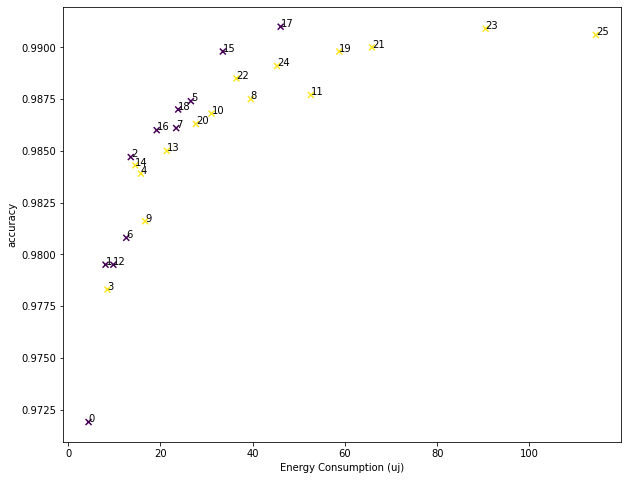

In [ ]:
plot_scatter(enj,acc,"Energy Consumption (uj)","accuracy")

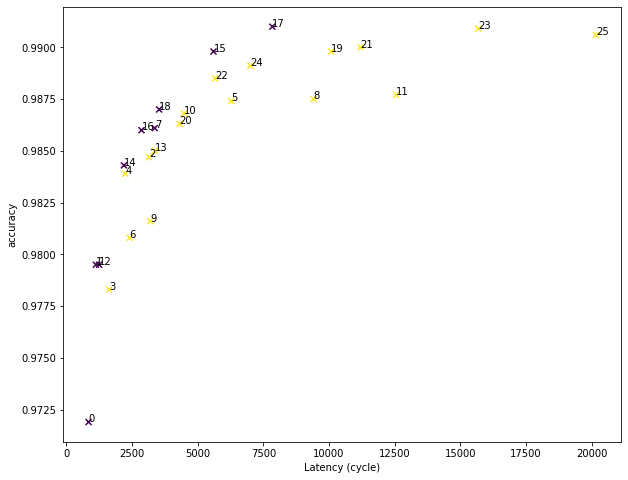

In [ ]:
plot_scatter(lat,acc,"Latency (cycle)","accuracy")

# Next Step

1.   **Search Space?**
        *   DNN Hyperparameters
        *   Accelerator Parameters (Size of GLB, SoC, RF memory, # of PEs, bandwidth, Technology, Supply voltage, ...) 


2.   **Searching Strategy?**
        *   Bayesian
        *   Evolutionary 
        *   Random search
        *   NAS
        
        




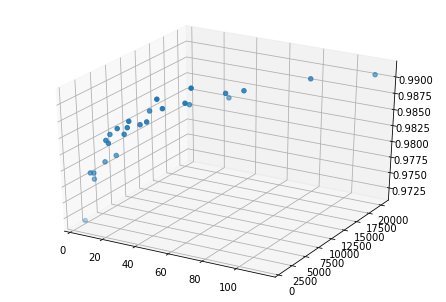

In [ ]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(enj, lat, acc)
ax.
pyplot.show()